In [25]:
import os
import json
import numpy as np
from collections import defaultdict
from scipy.spatial.transform import Rotation as R

# 디렉토리 설정
base_dirs = ["./ArUco_cap_panda"]
output_dir = "./Correct_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[2]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for base_dir in base_dirs:
    if not os.path.exists(base_dir):
        continue
    for fname in os.listdir(base_dir):
        if not fname.endswith('.json'):
            continue
        view, cam = parse_filename(fname)
        with open(os.path.join(base_dir, fname), 'r') as f:
            content = json.load(f)
            for marker_id, marker_data in content.items():
                data[view][cam][marker_id].append(marker_data)
                
# 회전 평균 함수
def average_quaternion(quaternions):
    M = np.zeros((4, 4))
    for q in quaternions:
        q = q.reshape(4, 1)
        M += q @ q.T
    eigvals, eigvecs = np.linalg.eigh(M)
    avg_quat = eigvecs[:, np.argmax(eigvals)]
    return avg_quat / np.linalg.norm(avg_quat)

# 각도 차이(degree) 계산 함수
def angular_distance_deg(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    relative_rot = r1.inv() * r2
    return np.rad2deg(relative_rot.magnitude())

# 위치 평균
def average_position(positions):
    return np.mean(positions, axis=0)
           
# 마커 정리 및 저장
for view in data:
    for cam in data[view]:
        corrected = {}
        for marker_id, entries in data[view][cam].items():
            if len(entries) < 1:
                continue  # 최소 두 개 이상 있어야 평균

            positions = [np.array([m['position_m']['x'], m['position_m']['y'], m['position_m']['z']]) for m in entries]
            quaternions = [np.array([m['rotation_quat']['x'], m['rotation_quat']['y'],
                                     m['rotation_quat']['z'], m['rotation_quat']['w']]) for m in entries]

            # 초기 평균 계산
            avg_quat_initial = average_quaternion(np.array(quaternions))

            # outlier 제거 (5도 이상 차이)
            filtered_positions = []
            filtered_quaternions = []
            for pos, quat in zip(positions, quaternions):
                if angular_distance_deg(avg_quat_initial, quat) <= 1.0:
                    filtered_positions.append(pos)
                    filtered_quaternions.append(quat)
                else:
                    print(f"Outlier detected for marker {marker_id} in {view}_{cam}: {quat}")

            if len(filtered_positions) == 0:
                continue  # outlier 제거 후 데이터 없음

            avg_pos = average_position(filtered_positions)
            avg_quat = average_quaternion(np.array(filtered_quaternions))

            corrected[marker_id] = {
                "position_m": {"x": float(avg_pos[0]), "y": float(avg_pos[1]), "z": float(avg_pos[2])},
                "rotation_quat": {"x": float(avg_quat[0]), "y": float(avg_quat[1]),
                                  "z": float(avg_quat[2]), "w": float(avg_quat[3])},
                "corners_pixel": entries[0]["corners_pixel"]
            }

        # 저장
        output_path = os.path.join(output_dir, f"{view}_{cam}_corrected.json")
        with open(output_path, 'w') as f:
            json.dump(corrected, f, indent=4)

print(f"Corrected data saved to {output_dir}")

Corrected data saved to ./Correct_ArUco


Processing ./Correct_ArUco/front_leftcam_corrected.json and ./Calib_cam_from_conf/view1_41182735_leftcam_calib.json
각 개별 마커의 자세를 시각화합니다...


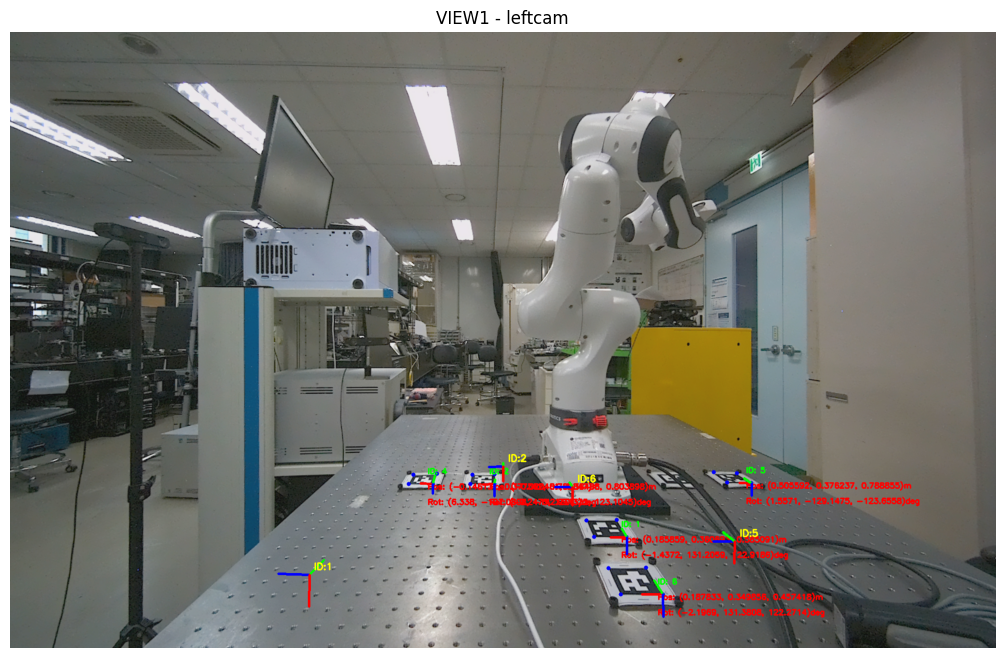

Processing ./Correct_ArUco/front_rightcam_corrected.json and ./Calib_cam_from_conf/view1_41182735_rightcam_calib.json
각 개별 마커의 자세를 시각화합니다...


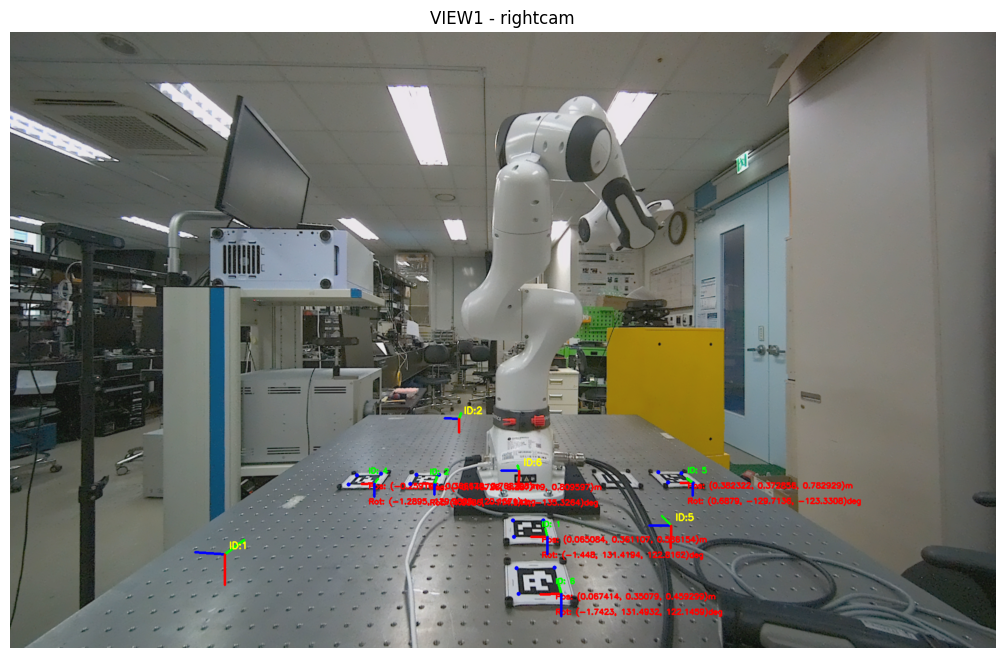

Processing ./Correct_ArUco/right_leftcam_corrected.json and ./Calib_cam_from_conf/view2_49429257_leftcam_calib.json
Processing ./Correct_ArUco/right_rightcam_corrected.json and ./Calib_cam_from_conf/view2_49429257_rightcam_calib.json
Processing ./Correct_ArUco/left_leftcam_corrected.json and ./Calib_cam_from_conf/view3_44377151_leftcam_calib.json
Processing ./Correct_ArUco/left_rightcam_corrected.json and ./Calib_cam_from_conf/view3_44377151_rightcam_calib.json
Processing ./Correct_ArUco/top_leftcam_corrected.json and ./Calib_cam_from_conf/view4_49045152_leftcam_calib.json
Processing ./Correct_ArUco/top_rightcam_corrected.json and ./Calib_cam_from_conf/view4_49045152_rightcam_calib.json


In [53]:
import numpy as np
import os
import glob
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# -------------------- 설정값 --------------------
image_dir = "./ArUco_cap_panda"
json_dir = "./Correct_ArUco"
calib_dir = "./Calib_cam_from_conf"
views = ['view1', 'view2', 'view3', 'view4']
cams = ['leftcam', 'rightcam']

# 시리얼 ↔ 위치 맵
camera_serials = {
    41182735: "view1", # front # marker 1, 2, 4, 5, 6
    49429257: "view2", # right # marker 2, 4, 7, 8
    44377151: "view3", # left  # marker 3, 5, 7, 8
    49045152: "view4"  # top   # marker 1, 2, 4, 6, 7, 8
}

serial_map = {v: k for k, v in camera_serials.items()}

camera_position_map = {
    41182735: "front",
    49429257: "right",
    44377151: "left",
    49045152: "top"
}

# <--- 수정: 좌표축 의미에 대한 주석 추가
# marker_offsets: 객체 기준점(Origin)에서 각 마커 중심까지의 상대 거리 (단위: 미터)
# 이 좌표계는 사용자가 정의하기 나름이며, 일반적인 로봇/카메라 좌표계를 따릅니다.
# +X: 좌우 축
# +Y: 높이 축
# +Z: 상하 축
marker_offsets = {
    "view1": {
        "1": np.array([0.5, 0.0, 0.0]), "2": np.array([0.0, 0.5, 0.0]), "3": np.array([0.0, 0.0, 0.0]),
        "4": np.array([0.0, 0.0, 0.5]), "5": np.array([0.0, 0.05, 0.06]), "6": np.array([0.0, 0.6, 0.0]),
        "7": np.array([0.0, 0.0, 0.0]), "8": np.array([0.0, 0.0, 0.0])
    },
    "view2": {
        "1": np.array([0.0, 0.0, 0.0]), "2": np.array([0.0, 0.0, 0.0]), "3": np.array([0.0, 0.0, 0.0]),
        "4": np.array([0.0, 0.0, 0.0]), "5": np.array([0.0, 0.0, 0.0]), "6": np.array([0.0, 0.0, 0.0]),
        "7": np.array([0.0, 0.0, 0.0]), "8": np.array([0.0, 0.0, 0.0])
    },
    "view3": {
        "1": np.array([0.0, 0.0, 0.0]), "2": np.array([0.0, 0.0, 0.0]), "3": np.array([0.0, 0.0, 0.0]),
        "4": np.array([0.0, 0.0, 0.0]), "5": np.array([0.0, 0.0, 0.0]), "6": np.array([0.0, 0.0, 0.0]),
        "7": np.array([0.0, 0.0, 0.0]), "8": np.array([0.0, 0.0, 0.0])
    },
    "view4": {
        "1": np.array([0.0, 0.0, 0.0]), "2": np.array([0.0, 0.0, 0.0]), "3": np.array([0.0, 0.0, 0.0]),
        "4": np.array([0.0, 0.0, 0.0]), "5": np.array([0.0, 0.0, 0.0]), "6": np.array([0.0, 0.0, 0.0]),
        "7": np.array([0.0, 0.0, 0.0]), "8": np.array([0.0, 0.0, 0.0])
    }
}

# -------------------- 결과 저장용 --------------------
summary = []
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale_axis = 0.3
font_scale_marker = 0.6
thickness_axis = 2
thickness_marker = 2

for view in views:
    serial = serial_map[view]
    pre_view = camera_position_map[serial]
    for cam in cams:
        pose_path = os.path.join(json_dir, f"{pre_view}_{cam}_corrected.json")
        calib_path = os.path.join(calib_dir, f"{view}_{serial}_{cam}_calib.json")
        print(f"Processing {pose_path} and {calib_path}")
        
        if not (os.path.exists(pose_path) and os.path.exists(calib_path)):
            continue

        with open(pose_path) as f:
            poses = json.load(f)
        with open(calib_path) as f:
            calib = json.load(f)

        K = np.array(calib["camera_matrix"], dtype=np.float64)
        dist = np.array(calib["distortion_coeffs"], dtype=np.float64)

        # 마커별 좌표 리스트 생성
        pts_world = [(mid, np.array([p["position_m"]["x"], p["position_m"]["y"], p["position_m"]["z"]]))
                     for mid, p in poses.items() if mid in marker_offsets[view]]

        if not pts_world:
            continue

        base_positions = np.vstack([b for _, b in pts_world])
        mean_base = base_positions.mean(axis=0)
        std_base = base_positions.std(axis=0)

        # tvec, rvec 계산 (오프셋 적용 후)
        tvecs, rvecs, marker_ids = [], [], []
        for mid, offset in marker_offsets[view].items():
            # <--- 수정: offset이 0 벡터인 경우 계산에서 제외하는 조건 추가
            if mid not in poses or np.all(offset == 0):
                continue
            
            p = poses[mid]
            tvec = np.array([p["position_m"]["x"], p["position_m"]["y"], p["position_m"]["z"]])
            quat = np.array([p["rotation_quat"][k] for k in ("x", "y", "z", "w")])
            rvec = R.from_quat(quat).as_rotvec()
            Rm = R.from_quat(quat).as_matrix()
            tvec_with_offset = tvec + Rm.dot(offset)
            tvecs.append(tvec_with_offset)
            rvecs.append(rvec)
            marker_ids.append(mid)

        if not tvecs:
            continue

        # <--- 수정: 기준 마커를 찾을 때도 0-offset 마커는 제외
        valid_mids = [mid for mid in marker_offsets[view] if mid in poses and not np.all(marker_offsets[view][mid] == 0)]
        if not valid_mids:
            continue # 유효한 마커가 없으면 다음으로 넘어감
            
        ref_mid = min(valid_mids, key=lambda m: np.linalg.norm(marker_offsets[view][m]))
        ref_quat = np.array([poses[ref_mid]["rotation_quat"][k] for k in ("x", "y", "z", "w")])
        R_ref = R.from_quat(ref_quat).as_matrix()

        R_all = [R_ref.T @ R.from_quat(np.array([poses[mid]["rotation_quat"][k] for k in ("x", "y", "z", "w")])).as_matrix()
                 for mid in marker_ids]

        R_all_stack = np.stack(R_all)
        R_mean_relative = R.from_matrix(R_all_stack).mean()
        R_mean_global = R.from_matrix(R_ref @ R_mean_relative.as_matrix())
        mean_rvec = R_mean_global.as_rotvec()
        mean_tvec = np.mean(tvecs, axis=0)

        # 이미지 로드
        img_files = glob.glob(os.path.join(image_dir, f"{pre_view}_*_{cam}_*.png"))
        if not img_files:
            continue
        img = cv2.imread(img_files[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 마커별 좌표축 및 ID 표시 (이제 0-offset 마커는 여기에 포함되지 않음)
        print("각 개별 마커의 자세를 시각화합니다...")
        for (rvec, tvec, mid) in zip(rvecs, tvecs, marker_ids):
            # 각 마커의 '고유한' 좌표축 그리기
            cv2.drawFrameAxes(img, K, dist, rvec, tvec.reshape(3, 1), 0.05)
            
            # 각 마커의 ID 텍스트를 표시하기 위해 '고유한' tvec을 2D로 투영
            marker_pos_2d, _ = cv2.projectPoints(tvec.reshape(1, 3), np.zeros((3,1)), np.zeros((3,1)), K, dist)
            x_marker, y_marker = marker_pos_2d.ravel().astype(int)
            cv2.putText(img, f"ID:{mid}", (x_marker + 10, y_marker - 10), font, font_scale_marker, (255, 255, 0), thickness_marker)

        # 평균 좌표계 시각화
        # print("계산된 평균 자세를 시각화합니다...")
        # # '평균' 회전축 그리기
        # cv2.drawFrameAxes(img, K, dist, mean_rvec.reshape(3, 1), mean_tvec.reshape(3, 1), 0.05)

        # # '평균' 위치(녹색 십자선)를 표시하기 위해 'mean_tvec'을 2D로 투영
        # point_to_project = mean_tvec.reshape(1, 1, 3)
        # projected_point, _ = cv2.projectPoints(point_to_project, np.zeros((3,1)), np.zeros((3,1)), K, dist)
        # xm, ym = projected_point.ravel().astype(int)
        # cv2.drawMarker(img, (xm, ym), (0, 255, 0), cv2.MARKER_CROSS, 20, 2)

        # # '평균' 값에 대한 텍스트 정보 표시
        # mean_rvec_deg = np.rad2deg(mean_rvec)
        # rvec_text = f"Rvec [deg]: {mean_rvec_deg[0]:.1f}, {mean_rvec_deg[1]:.1f}, {mean_rvec_deg[2]:.1f}"
        # cv2.putText(img, rvec_text, (xm + 5, ym + 20), font, 0.5, (0, 255, 255), 2)

        # 시각화
        plt.figure(figsize=(16, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{view.upper()} - {cam}")
        plt.show()

# -------------------- 결과 저장 --------------------
columns = ["view", "cam", "mean_x", "mean_y", "mean_z",
           "std_x", "std_y", "std_z", "proj_x", "proj_y",
           "tvec_x", "tvec_y", "tvec_z",
           "rvec_x", "rvec_y", "rvec_z"]
df = pd.DataFrame(summary, columns=columns)

output_dir = "./result_output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "aruco_pose_summary.json")
df.to_json(output_path, orient="records", indent=2)